In [2]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import uuid
import datetime

# --- KONFIGURASI DATA SIMULASI ---
NUM_REVIEWS = 1000  # Jumlah baris data yang akan dibuat (Ditingkatkan dari 33 ke 1000)
NUM_GUIDES = 30     # Jumlah Pemandu Wisata unik
OUTPUT_FILE = 'reddit_data_mentah.csv' # Nama file output

fake = Faker('en_US')

# Daftar Kata Kunci untuk Ulasan Positif dan Negatif
POSITIVE_WORDS = ['great', 'excellent', 'amazing', 'love', 'fantastic', 'friendly', 'awesome', 'wonderful','superb', 'brilliant', 'outstanding', 'incredible', 'nice', 'pleasant', 'good', 'helpful','kind', 'positive', 'satisfied', 'happy', 'delightful', 'terrific', 'marvelous', 'impressive','enjoyable', 'perfect', 'professional', 'efficient', 'reliable', 'affordable', 'cool','lovely', 'appreciate', 'fast', 'clean', 'smooth', 'comfortable', 'trustworthy','excellent', 'supportive', 'responsive', 'polite', 'honest', 'beautiful', 'recommend','fantabulous', 'outstanding', 'pleased', 'top', 'best', 'super', 'fine', 'helpful','satisfying', 'cheerful', 'grateful', 'respectful', 'welcoming', 'generous'
]
NEGATIVE_WORDS = ['bad', 'terrible', 'awful', 'horrible', 'poor', 'slow', 'disappointed', 'worse', 'worst','useless', 'rude', 'lazy', 'dirty', 'ugly', 'boring', 'annoying', 'frustrating', 'unfriendly','unprofessional', 'broken', 'expensive', 'waste', 'delay', 'horrid', 'disgusting', 'hate','unhelpful', 'horrendous', 'pathetic', 'incompetent', 'unreliable', 'faulty', 'problematic','unpleasant', 'careless', 'unresponsive', 'ignorant', 'slowest', 'ridiculous', 'stupid','crap', 'awfully', 'terribly', 'disaster', 'lousy', 'messy', 'weak', 'insecure', 'confusing','noisy', 'painful', 'embarrassing', 'stressful', 'tired', 'buggy', 'laggy']


def generate_review_data(num_reviews):
    """Menghasilkan DataFrame dengan ulasan pemandu wisata yang realistis."""
    data = []
    
    # Buat ID Pemandu yang unik
    guide_ids = [uuid.uuid4().hex[:8] for _ in range(NUM_GUIDES)]
    
    for _ in range(num_reviews):
        guide_id = random.choice(guide_ids)
        rating = random.choices([1, 2, 3, 4, 5], weights=[5, 10, 15, 30, 40], k=1)[0] # Rating lebih cenderung positif
        
        # Buat teks ulasan berdasarkan rating
        review_parts = []
        if rating >= 4:
            # Ulasan yang baik lebih panjang dan mengandung kata positif
            review_parts.append(random.choice(POSITIVE_WORDS))
            review_parts.append(fake.sentence(nb_words=10))
            if random.random() < 0.3:
                 review_parts.append(random.choice(["Best guide ever", "highly recommend", "not bad"]))
        elif rating <= 2:
            # Ulasan yang buruk mengandung kata negatif
            review_parts.append(random.choice(NEGATIVE_WORDS))
            review_parts.append(fake.sentence(nb_words=8))
            if random.random() < 0.5:
                review_parts.append(random.choice(["absolutely terrible", "waste of time", "never again"]))
        else:
            review_parts.append(fake.sentence(nb_words=12))

        review_text = " ".join(review_parts)
        
        data.append({
            'comment_id': uuid.uuid4().hex,
            'guide_id': guide_id,
            'body': review_text,
            'rating_bintang': rating,
            'created_utc': fake.date_time_between(start_date='-1y', end_date='now', tzinfo=datetime.timezone.utc)
        })
        
    df = pd.DataFrame(data)
    # Ganti nama kolom 'body' menjadi 'review_text' untuk memudahkan pemrosesan nanti
    df = df.rename(columns={'body': 'review_text'})
    return df

# --- EKSEKUSI DAN PENYIMPANAN ---
df_mentah = generate_review_data(NUM_REVIEWS)
df_mentah.to_csv(OUTPUT_FILE, index=False)

print("=======================================================")
print(f"✅ GENERASI DATA DUMMY SELESAI")
print("=======================================================")
print(f"Total {len(df_mentah)} baris data ulasan pemandu wisata dibuat.")
print(f"Data disimpan ke: {OUTPUT_FILE}")
print("\nContoh Data:")
print(df_mentah[['review_text', 'rating_bintang']].head())

✅ GENERASI DATA DUMMY SELESAI
Total 1000 baris data ulasan pemandu wisata dibuat.
Data disimpan ke: reddit_data_mentah.csv

Contoh Data:
                                         review_text  rating_bintang
0          awesome Fear myself role home art second.               5
1  Authority rich final war let money month eveni...               3
2  broken Kind even begin general air once agree ...               2
3  appreciate Paper all wait woman his place. Bes...               4
4  cool Voice reason same age offer name notice o...               5


In [6]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
import time 

# --- KONFIGURASI FILE & BOBOT (Sesuai dengan Model Kustom Anda) ---
FILE_NAME = 'reddit_data_mentah.csv'
CLEANED_OUTPUT_FILE = 'guide_sentiment_hybrid_data.csv'

RATING_BOBOT = 0.08
BOBOT_BAIK_TUNGGAL = 0.02
BOBOT_BURUK_TUNGGAL = -0.01

# --- LEXICON FRASA EKSPRESIF ---
FRASA_POS_INTENS = {
    'absolutely amazing': 0.10, 'best guide ever': 0.15, 'highly recommend': 0.08, 
    'what a badass': 0.10, 'not bad': 0.05
}
FRASA_NEG_INTENS = {
    'absolutely terrible': -0.04, 'waste of time': -0.05, 
    'disappointed me so much': -0.05, 'never again': -0.05
}

# --- DAFTAR KATA TUNGGAL (DIBERSIHKAN DARI KATA FRASA) ---
# Menggabungkan daftar kata Anda, lalu menghapus kata-kata yang sudah ada di frasa intens
KATA_BAIK_TUNGGAL_SET = {'great', 'excellent', 'amazing', 'love', 'fantastic', 'friendly', 'awesome', 'wonderful','superb', 'brilliant', 'outstanding', 'incredible', 'nice', 'pleasant', 'good', 'helpful','kind', 'positive', 'satisfied', 'happy', 'delightful', 'terrific', 'marvelous', 'impressive','enjoyable', 'perfect', 'professional', 'efficient', 'reliable', 'affordable', 'cool','lovely', 'appreciate', 'fast', 'clean', 'smooth', 'comfortable', 'trustworthy','supportive', 'responsive', 'polite', 'honest', 'beautiful', 'recommend','fantabulous', 'pleased', 'top', 'best', 'super', 'fine', 'helpful','satisfying', 'cheerful', 'grateful', 'respectful', 'welcoming', 'generous'}

KATA_BURUK_TUNGGAL_SET = {'bad', 'terrible', 'awful', 'horrible', 'poor', 'slow', 'disappointed', 'worse', 'worst','useless', 'rude', 'lazy', 'dirty', 'ugly', 'boring', 'annoying', 'frustrating', 'unfriendly','unprofessional', 'broken', 'expensive', 'waste', 'delay', 'horrid', 'disgusting', 'hate','unhelpful', 'horrendous', 'pathetic', 'incompetent', 'unreliable', 'faulty', 'problematic','unpleasant', 'careless', 'unresponsive', 'ignorant', 'slowest', 'ridiculous', 'stupid','crap', 'awfully', 'terribly', 'disaster', 'lousy', 'messy', 'weak', 'insecure', 'confusing','noisy', 'painful', 'embarrassing', 'stressful', 'tired', 'buggy', 'laggy'}

# --- PENCEGAHAN DOUBLE COUNTING (Hapus kata dari daftar tunggal jika ada di frasa) ---
# Hanya contoh: mengambil kata-kata kunci dari frasa (misalnya, 'absolutely', 'amazing')
def get_words_from_phrases(phrase_dict):
    words = set()
    for phrase in phrase_dict.keys():
        words.update(phrase.split())
    return words

ALL_PHRASE_WORDS = get_words_from_phrases(FRASA_POS_INTENS) | get_words_from_phrases(FRASA_NEG_INTENS)
KATA_BAIK_TUNGGAL_SET -= ALL_PHRASE_WORDS
KATA_BURUK_TUNGGAL_SET -= ALL_PHRASE_WORDS


# --- SETUP DAN MUAT DATA ---
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

try:
    df = pd.read_csv(FILE_NAME)
    df = df.rename(columns={'rating_bintang': 'rating'}) 
except FileNotFoundError:
    print(f"ERROR: File '{FILE_NAME}' tidak ditemukan. Jalankan script generator data.")
    exit()

# ------------------------------------------------------------------

### 2. Fungsi Pre-Processing Teks

def clean_and_normalize_text(text):
    """Membersihkan teks untuk TF-IDF dan menghapus stop words."""
    text = re.sub(r'[^a-zA-Z\s]', '', str(text), re.I|re.A).lower() 
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(tokens)

### 3. Fungsi Model Sentimen Hibrida

def hitung_bobot_komentar_total(review_text):
    """Menghitung total bobot komentar dari kata tunggal dan frasa ekspresif."""
    skor_komentar = 0
    text_lower = str(review_text).lower()
    
    # 1. Hitung Frasa Ekspresif (Paling Prioritas)
    for phrase, bobot in {**FRASA_POS_INTENS, **FRASA_NEG_INTENS}.items():
        if re.search(r'\b' + re.escape(phrase) + r'\b', text_lower):
            skor_komentar += bobot
            
    # 2. Hitung Kata Tunggal (pada teks yang sudah di-clean dasar)
    text_clean_tokens = [word for word in text_lower.split() if word not in stop_words]
    for word in text_clean_tokens:
        if word in KATA_BAIK_TUNGGAL_SET:
            skor_komentar += BOBOT_BAIK_TUNGGAL
        elif word in KATA_BURUK_TUNGGAL_SET:
            skor_komentar += BOBOT_BURUK_TUNGGAL
            
    return skor_komentar

def hitung_sentimen_hibrida(row):
    """Menghitung skor sentimen total dengan Capping [0.1, 0.5]."""
    rating_bintang = row['rating']
    bobot_komentar = row['bobot_komentar_raw']
    
    bobot_rating = rating_bintang * RATING_BOBOT
    skor_mentah = bobot_rating + bobot_komentar
    
    # Pembatasan/Capping (0.1 hingga 0.5)
    final_score = np.clip(skor_mentah, 0.1, 0.5)
        
    return final_score

# ------------------------------------------------------------------

# --- EKSEKUSI MODEL SENTIMEN DAN PRE-PROCESSING ---

print("Memulai pemrosesan teks dan implementasi Model Sentimen Hibrida...")

# 1. Kolom untuk Clustering (Teks yang sudah bersih)
df.loc[:, 'processed_body'] = df['review_text'].apply(clean_and_normalize_text)

# 2. Kolom untuk Model Hibrida (Bobot dari teks)
df.loc[:, 'bobot_komentar_raw'] = df['review_text'].apply(hitung_bobot_komentar_total)

# 3. Kolom Skor Final
df.loc[:, 'Final_Sentiment_Score'] = df.apply(hitung_sentimen_hibrida, axis=1)

# Hapus baris kosong yang mungkin muncul setelah pembersihan
df_final = df[df['processed_body'].str.strip() != ''].copy()

# --- FINALISASI DATA DAN SIMPAN ---
df_final.to_csv(CLEANED_OUTPUT_FILE, index=False)

print("\n=======================================================")
print("✅ IMPLEMENTASI MODEL SENTIMEN HIBRIDA SELESAI")
print("=======================================================")
print(f"Total baris data yang siap diolah: {len(df_final)}")
print(f"Data disimpan ke: {CLEANED_OUTPUT_FILE}")
print("\nContoh Hasil Model:")
print(df_final[['review_text', 'rating', 'bobot_komentar_raw', 'Final_Sentiment_Score']].head())

Memulai pemrosesan teks dan implementasi Model Sentimen Hibrida...

✅ IMPLEMENTASI MODEL SENTIMEN HIBRIDA SELESAI
Total baris data yang siap diolah: 1000
Data disimpan ke: guide_sentiment_hybrid_data.csv

Contoh Hasil Model:
                                         review_text  rating  \
0          awesome Fear myself role home art second.       5   
1  Authority rich final war let money month eveni...       3   
2  broken Kind even begin general air once agree ...       2   
3  appreciate Paper all wait woman his place. Bes...       4   
4  cool Voice reason same age offer name notice o...       5   

   bobot_komentar_raw  Final_Sentiment_Score  
0                0.02                   0.42  
1                0.00                   0.24  
2               -0.03                   0.13  
3                0.17                   0.49  
4                0.02                   0.42  


In [10]:
(df_final['rating'].max())

np.int64(5)

In [11]:
# Asumsi: df_final sudah dimuat dan memiliki 'Final_Sentiment_Score' dan 'guide_id'

def aggregate_guide_performance(df_data):
    """Mengagregasi semua skor ulasan per guide_id."""
    
    guide_ranking_df = df_data.groupby('guide_id').agg(
        # Metrik Kunci
        total_reviews=('comment_id', 'count'),
        avg_final_score=('Final_Sentiment_Score', 'mean'),
        # Metrik Sekunder (untuk insight)
        avg_rating_bintang=('rating', 'mean'),
        max_negative_bobot=('bobot_komentar_raw', 'min') # Cari ulasan paling negatif
    ).reset_index()
    
    # Kriteria Mutlak: Pemandu harus memiliki minimal 5 ulasan untuk di-rank
    MIN_REVIEWS_THRESHOLD = 5 
    guide_ranking_df = guide_ranking_df[guide_ranking_df['total_reviews'] >= MIN_REVIEWS_THRESHOLD].copy()
    
    # Hitung Ranking Final berdasarkan skor hibrida
    guide_ranking_df = guide_ranking_df.sort_values(by='avg_final_score', ascending=False)
    guide_ranking_df['rank'] = np.arange(1, len(guide_ranking_df) + 1)
    
    return guide_ranking_df

# --- EKSEKUSI TAHAP 4 ---
guide_ranking_final = aggregate_guide_performance(df_final)

print("\n--- Tahap 4: Agregasi Kinerja Pemandu Selesai ---")
print(guide_ranking_final.head())


--- Tahap 4: Agregasi Kinerja Pemandu Selesai ---
    guide_id  total_reviews  avg_final_score  avg_rating_bintang  \
8   4d75fffb             34         0.370588            4.176471   
28  fd570222             26         0.370385            4.153846   
26  f048a6c1             34         0.369706            4.088235   
29  febbca88             32         0.367813            4.156250   
25  d1a29087             25         0.367600            4.200000   

    max_negative_bobot  rank  
8                -0.06     1  
28               -0.01     2  
26               -0.06     3  
29               -0.01     4  
25               -0.01     5  


In [12]:
def get_top_recommendations(ranking_df, top_n=5):
    """Mengambil pemandu dengan skor hibrida tertinggi."""
    return ranking_df.head(top_n)

# --- EKSEKUSI TAHAP 5 ---
top_5_guides = get_top_recommendations(guide_ranking_final)

print("\n--- Pemandu Terbaik (Top 5 Rekomendasi) ---")
print(top_5_guides[['guide_id', 'avg_final_score', 'avg_rating_bintang', 'total_reviews']])


--- Pemandu Terbaik (Top 5 Rekomendasi) ---
    guide_id  avg_final_score  avg_rating_bintang  total_reviews
8   4d75fffb         0.370588            4.176471             34
28  fd570222         0.370385            4.153846             26
26  f048a6c1         0.369706            4.088235             34
29  febbca88         0.367813            4.156250             32
25  d1a29087         0.367600            4.200000             25


In [13]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import uuid

# Inisialisasi Faker
fake = Faker('en_US') 

# --- KONFIGURASI FILE (Digunakan dari Tahap Sebelumnya) ---
CLEANED_OUTPUT_FILE = 'guide_sentiment_hybrid_data.csv'

# ASUMSI: df_final sudah dimuat dari file CLEANED_OUTPUT_FILE
try:
    df_final = pd.read_csv(CLEANED_OUTPUT_FILE)
except FileNotFoundError:
    print(f"ERROR: File '{CLEANED_OUTPUT_FILE}' tidak ditemukan. Pastikan Anda sudah menjalankan script preprocessing sebelumnya.")
    exit()

# ------------------------------------------------------------------

def generate_guide_names(guide_ids):
    """Menghasilkan nama dua suku kata unik untuk setiap guide_id."""
    name_map = {}
    
    for guide_id in guide_ids:
        # Menghasilkan nama depan dan nama belakang, lalu menggabungkannya
        full_name = f"{fake.first_name()} {fake.last_name()}"
        name_map[guide_id] = full_name
        
    # Mengembalikan DataFrame Pandas (guide_id, guide_name)
    return pd.DataFrame(list(name_map.items()), columns=['guide_id', 'guide_name'])

def aggregate_guide_performance(df_data):
    """Mengagregasi semua skor ulasan per guide_id."""
    
    # 1. Agregasi Skor
    guide_ranking_df = df_data.groupby('guide_id').agg(
        total_reviews=('comment_id', 'count'),
        avg_final_score=('Final_Sentiment_Score', 'mean'),
        avg_rating_bintang=('rating', 'mean'),
        max_negative_bobot=('bobot_komentar_raw', 'min') 
    ).reset_index()
    
    # 2. Threshold (Minimal 5 ulasan)
    MIN_REVIEWS_THRESHOLD = 5 
    guide_ranking_df = guide_ranking_df[guide_ranking_df['total_reviews'] >= MIN_REVIEWS_THRESHOLD].copy()
    
    # 3. GENERATE DAN MERGE NAMA BARU
    
    # Dapatkan semua guide_id unik yang tersisa setelah filtering
    unique_guide_ids = guide_ranking_df['guide_id'].unique()
    
    # Generate nama untuk ID unik ini
    name_lookup = generate_guide_names(unique_guide_ids)
    
    # Merge nama ke DataFrame ranking
    guide_ranking_df = pd.merge(
        guide_ranking_df, 
        name_lookup, 
        on='guide_id', 
        how='left'
    )
    
    # 4. Hitung Ranking Final
    guide_ranking_df = guide_ranking_df.sort_values(by='avg_final_score', ascending=False)
    guide_ranking_df['rank'] = np.arange(1, len(guide_ranking_df) + 1)
    
    return guide_ranking_df

# --- EKSEKUSI TAHAP AKHIR ---
guide_ranking_final = aggregate_guide_performance(df_final)

# Simpan hasil akhir yang sudah mengandung nama pemandu
FINAL_RANKING_OUTPUT = 'guide_ranking_final.csv'
guide_ranking_final.to_csv(FINAL_RANKING_OUTPUT, index=False)


print("\n=======================================================")
print("✅ AGREGASI & PENAMBAHAN NAMA SELESAI")
print("=======================================================")
print(f"File ranking akhir disimpan ke: {FINAL_RANKING_OUTPUT}")
print("\nContoh Hasil Akhir (Termasuk Nama):")
print(guide_ranking_final[['rank', 'guide_id', 'guide_name', 'avg_final_score', 'total_reviews']].head(10))


✅ AGREGASI & PENAMBAHAN NAMA SELESAI
File ranking akhir disimpan ke: guide_ranking_final.csv

Contoh Hasil Akhir (Termasuk Nama):
    rank  guide_id       guide_name  avg_final_score  total_reviews
8      1  4d75fffb   Kenneth Warner         0.370588             34
28     2  fd570222      Karen Ayala         0.370385             26
26     3  f048a6c1    Kelly Jenkins         0.369706             34
29     4  febbca88   Jennifer Giles         0.367812             32
25     5  d1a29087      Joseph Webb         0.367600             25
6      6  422e5f4a       Donna Lynn         0.363714             35
3      7  25c695dd        Willie Wu         0.362941             34
18     8  a111840c  Alexandra Kelly         0.357000             30
19     9  b0c118f3    Kenneth Green         0.356757             37
27    10  f59170ab       Kyle Kline         0.355854             41


In [16]:
import pandas as pd
import numpy as np

# Muat DataFrame hasil akhir yang sudah memiliki kedua skor
FILE_NAME = 'guide_ranking_final.csv'
try:
    df_ranking = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"ERROR: File '{FILE_NAME}' tidak ditemukan.")
    exit()

# 1. Hitung Ranking Berdasarkan Bintang Saja (Metode Lama)
df_ranking['rank_bintang'] = df_ranking['avg_rating_bintang'].rank(method='min', ascending=False).astype(int)

# 2. Hitung Ranking Berdasarkan Model Hibrida (Metode Baru)
df_ranking['rank_hibrida'] = df_ranking['avg_final_score'].rank(method='min', ascending=False).astype(int)

# 3. Hitung Selisih Ranking (Untuk Menemukan Anomali)
df_ranking['ranking_difference'] = df_ranking['rank_bintang'] - df_ranking['rank_hibrida']

# Sortir berdasarkan selisih terbesar untuk menemukan pemandu yang 'diturunkan'
# Ranking Difference positif (Bintang tinggi, Hibrida rendah) -> Pemandu Berisiko
df_anomali = df_ranking.sort_values(by='ranking_difference', ascending=False).head(5)


# ----------------------------------------------------
# PERBAIKAN: TAMBAHKAN OUTPUT UNTUK MELIHAT HASIL
# ----------------------------------------------------
print("="*40)
print("✅ 5 Pemandu Paling Berisiko (Anomali Kualitas)")
print("   (Ranking Bintang Jauh Lebih Baik dari Ranking Hibrida)")
print("="*40)
print(df_anomali[['guide_name', 'avg_rating_bintang', 'avg_final_score', 'ranking_difference', 'rank_bintang', 'rank_hibrida']])

✅ 5 Pemandu Paling Berisiko (Anomali Kualitas)
   (Ranking Bintang Jauh Lebih Baik dari Ranking Hibrida)
       guide_name  avg_rating_bintang  avg_final_score  ranking_difference  \
9      Kyle Kline            3.878049         0.355854                   7   
18    Dana Murray            3.703704         0.332593                   5   
2   Kelly Jenkins            4.088235         0.369706                   4   
5      Donna Lynn            4.085714         0.363714                   3   
8   Kenneth Green            4.000000         0.356757                   2   

    rank_bintang  rank_hibrida  
9             17            10  
18            24            19  
2              7             3  
5              9             6  
8             11             9  


In [19]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- KONFIGURASI FILE ---
CLEANED_OUTPUT_FILE = 'guide_sentiment_hybrid_data.csv'

# --- LEXICON KATA KUNCI ANDA (Hanya untuk Filtering) ---
# Kita gunakan set yang sudah Anda definisikan untuk memisahkan kata
KATA_BAIK_SEMUA = {'great', 'excellent', 'amazing', 'love', 'fantastic', 'friendly', 'awesome', 'wonderful','superb', 'brilliant', 'outstanding', 'incredible', 'nice', 'helpful','kind', 'positive', 'satisfied', 'happy', 'delightful', 'terrific', 'marvelous', 'impressive','enjoyable', 'perfect', 'professional', 'efficient', 'reliable', 'affordable', 'cool','lovely', 'appreciate', 'fast', 'clean', 'smooth', 'comfortable', 'trustworthy','supportive', 'responsive', 'polite', 'honest', 'beautiful', 'recommend','fantabulous', 'pleased', 'top', 'best', 'super', 'fine', 'helpful','satisfying', 'cheerful', 'grateful', 'respectful', 'welcoming', 'generous',
                   # Tambahan dari frasa ekspresif
                   'badass', 'not', 'absolutely', 'highly', 'guide', 'ever'} 

KATA_BURUK_SEMUA = {'bad', 'terrible', 'awful', 'horrible', 'poor', 'slow', 'disappointed', 'worse', 'worst','useless', 'rude', 'lazy', 'dirty', 'ugly', 'boring', 'annoying', 'frustrating', 'unfriendly','unprofessional', 'broken', 'expensive', 'waste', 'delay', 'horrid', 'disgusting', 'hate','unhelpful', 'horrendous', 'pathetic', 'incompetent', 'unreliable', 'faulty', 'problematic','unpleasant', 'careless', 'unresponsive', 'ignorant', 'slowest', 'ridiculous', 'stupid','crap', 'awfully', 'terribly', 'disaster', 'lousy', 'messy', 'weak', 'insecure', 'confusing','noisy', 'painful', 'embarrassing', 'stressful', 'tired', 'buggy', 'laggy',
                    # Tambahan dari frasa ekspresif
                    'absolutely', 'waste', 'time', 'disappointed', 'much', 'never', 'again'}

# Muat Data Bersih
try:
    df_clean = pd.read_csv(CLEANED_OUTPUT_FILE)
except FileNotFoundError:
    print(f"ERROR: File '{CLEANED_OUTPUT_FILE}' tidak ditemukan.")
    exit()

# Gabungkan semua teks dari kolom 'processed_body'
all_text = ' '.join(df_clean['processed_body'].astype(str).tolist())

In [20]:
# Hitung frekuensi setiap kata di seluruh dataset
word_counts = Counter(all_text.split())

# Inisialisasi dictionary untuk Word Cloud (hanya kata yang relevan)
good_freq = {}
bad_freq = {}

# Filter dan isi dictionary frekuensi
for word, count in word_counts.items():
    if word in KATA_BAIK_SEMUA:
        good_freq[word] = count
    elif word in KATA_BURUK_SEMUA:
        # Gunakan count sebagai bobot
        bad_freq[word] = count

print(f"Total kata positif unik ditemukan: {len(good_freq)}")
print(f"Total kata negatif unik ditemukan: {len(bad_freq)}")

Total kata positif unik ditemukan: 58
Total kata negatif unik ditemukan: 57


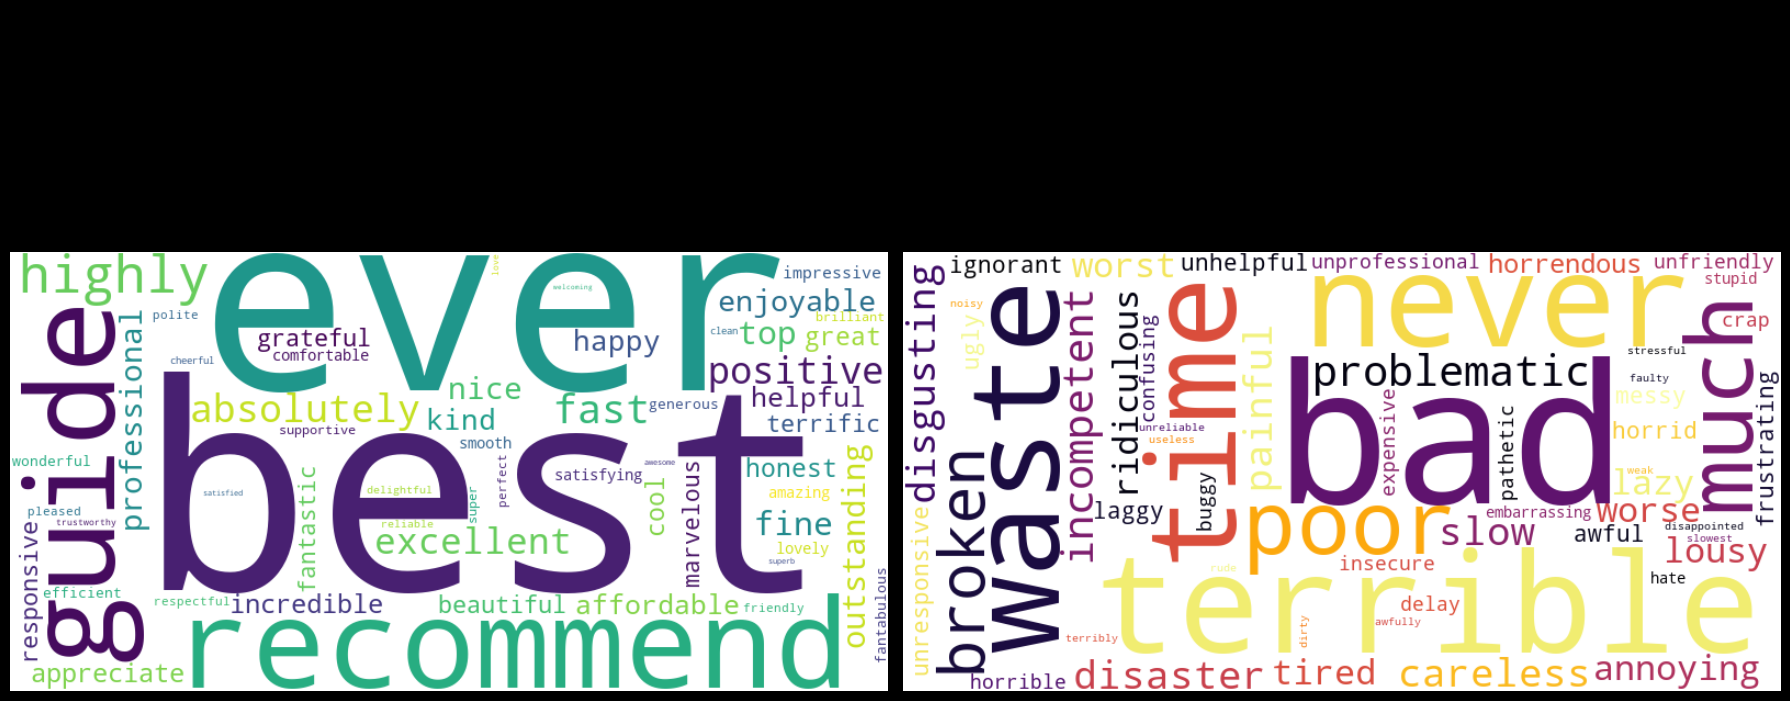


Visualisasi Word Cloud berbasis Frekuensi Aktual telah dieksekusi.


In [22]:
def generate_word_cloud_from_freq(word_freq, title, color_map):
    """Membuat dan menampilkan satu Word Cloud dari dictionary frekuensi."""
    
    wc = WordCloud(
        background_color="white", 
        width=800, 
        height=400, 
        max_words=100,
        colormap=color_map, 
        normalize_plurals=False
    )
    # Generate dari frekuensi (count) yang sudah dihitung
    wc.generate_from_frequencies(word_freq)

    plt.imshow(wc, interpolation="bilinear")
    plt.title(title, fontsize=18, color='black') 
    plt.axis("off")


# --- EKSEKUSI VISUALISASI ---

plt.style.use('default') 
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
fig.set_facecolor('blacK') 
fig.suptitle("Perbandingan Frekuensi Kata Aktual (Good vs. Bad)", fontsize=20, color='black')


# Visualisasi 1: Positif (GOOD)
plt.sca(axes[0]) 
generate_word_cloud_from_freq(good_freq, "Kata Kunci Positif (Frekuensi Aktual)", 'viridis') 


# Visualisasi 2: Negatif (BAD)
plt.sca(axes[1]) 
generate_word_cloud_from_freq(bad_freq, "Kata Kunci Negatif (Frekuensi Aktual)", 'inferno') 


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nVisualisasi Word Cloud berbasis Frekuensi Aktual telah dieksekusi.")

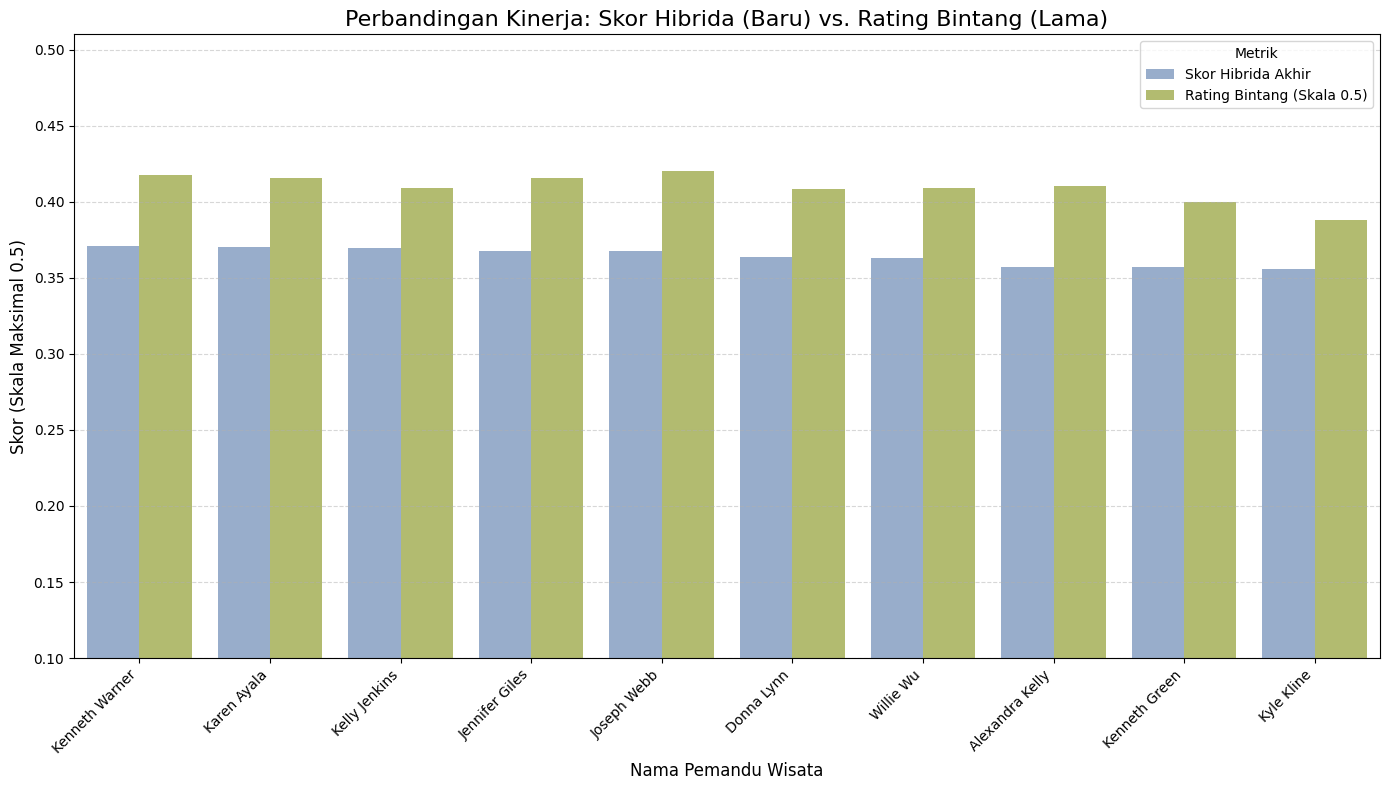

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- KONFIGURASI FILE ---
FINAL_RANKING_OUTPUT = 'guide_ranking_final.csv'

try:
    df_ranking = pd.read_csv(FINAL_RANKING_OUTPUT)
except FileNotFoundError:
    print(f"ERROR: File '{FINAL_RANKING_OUTPUT}' not found. Pastikan Anda sudah menjalankan script agregasi.")
    exit()

# Sortir berdasarkan skor hibrida (ranking terbaik di atas)
df_ranking = df_ranking.sort_values(by='avg_final_score', ascending=False)
df_top_10 = df_ranking.head(10).copy()

# --- FEATURE ENGINEERING UNTUK VISUALISASI ---

# Normalisasi Skor Bintang ke Skala 0-0.5 untuk perbandingan langsung
# Skor Bintang (1-5) * (0.5 / 5.0) = Rating di Skala [0.1, 0.5]
df_top_10.loc[:, 'rating_normalized'] = df_top_10['avg_rating_bintang'] * (0.5 / 5.0)


# --- MELT DATA UNTUK BAR CHART GABUNGAN (CLUSTERING) ---
# Mengubah format data dari wide ke long
df_melt = df_top_10.melt(
    id_vars=['guide_name'],
    value_vars=['avg_final_score', 'rating_normalized'],
    var_name='Metrik',
    value_name='Skor'
)

# Sesuaikan label
df_melt['Metrik'] = df_melt['Metrik'].replace({
    'rating_normalized': 'Rating Bintang (Skala 0.5)',
    'avg_final_score': 'Skor Hibrida Akhir'
})

# --- PLOTTING (Clustered Bar Chart) ---

plt.figure(figsize=(14, 8))

# Clustered Bar Chart: Menunjukkan dua bar (dua metrik) untuk setiap pemandu
sns.barplot(
    x='guide_name', 
    y='Skor', 
    hue='Metrik', 
    data=df_melt,
    palette={'Skor Hibrida Akhir': '#8FABD4', 'Rating Bintang (Skala 0.5)': '#BBC863'} # Hijau/Biru
)

# Label dan Pengaturan Visual
plt.title('Perbandingan Kinerja: Skor Hibrida (Baru) vs. Rating Bintang (Lama)', fontsize=16)
plt.xlabel('Nama Pemandu Wisata', fontsize=12)
plt.ylabel('Skor (Skala Maksimal 0.5)', fontsize=12)

# Atur batas Y-axis

plt.ylim(0.1, 0.51) 
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Metrik', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()